In [46]:
# Imports
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from pathlib import Path
import plotly.io as pio

import kaleido
kaleido.Kaleido

kaleido.kaleido.Kaleido

In [47]:
# static vars
eval_data_path = './evaluation'

LABEL_MAP = {
    "Gymnastik": "Gymnastics ball",
    "schwamm": "Sponge",
    "terabandMuster": "Exercise band\n(trackingmarker)",
    "teraband": "Exercise band\n(plain)",
}

# Read data

In [48]:
dirs = os.listdir(eval_data_path)
dirs.sort()
results = []

for eval_target in dirs:

    equipment_type, num_str, duration_str = eval_target.split('_')
    num = int(num_str)
    duration_s = int(duration_str.split('s')[0])


    target_path = f'{eval_data_path}/{eval_target}/analysis'
    if not os.path.exists(target_path):
        print(f'Could not find {target_path}')
        continue

    csv_path = os.path.join(target_path, 'metrics_per_frame.csv')
    json_path = os.path.join(target_path, 'metrics_summary.json')

    summary = {}
    if os.path.isfile(json_path):
        try:
            with open(json_path, 'r', encoding='utf-8') as f:
                summary = json.load(f)
        except Exception as e:
            print(f"Failed to read {json_path}: {e}")


        # Merge summary at top-level; meta keys override on collision
        entry = { # flatten fields from metrics_summary.json
            "equipment_type": equipment_type,
            "num": num,
            "duration_s": duration_s,
            "csv_path": csv_path,
            **summary
        }

        results.append(entry)

for elem in results:
    print(json.dumps(elem, indent=2, ensure_ascii=False, sort_keys=True))

{
  "average_accuracy_percent": 85.49753505958934,
  "correct_points_total": 71452,
  "csv_path": "./evaluation/Gymnastik_10_30s/analysis/metrics_per_frame.csv",
  "duration_s": 30,
  "equipment_type": "Gymnastik",
  "frames_analyzed": 900,
  "num": 10,
  "visible_points_total": 83572
}
{
  "average_accuracy_percent": 84.84617401043776,
  "correct_points_total": 71208,
  "csv_path": "./evaluation/Gymnastik_10_30s360/analysis/metrics_per_frame.csv",
  "duration_s": 30,
  "equipment_type": "Gymnastik",
  "frames_analyzed": 900,
  "num": 10,
  "visible_points_total": 83926
}
{
  "average_accuracy_percent": 90.74236232730104,
  "correct_points_total": 18653,
  "csv_path": "./evaluation/Gymnastik_1_5s/analysis/metrics_per_frame.csv",
  "duration_s": 5,
  "equipment_type": "Gymnastik",
  "frames_analyzed": 150,
  "num": 1,
  "visible_points_total": 20556
}
{
  "average_accuracy_percent": 91.33513646422425,
  "correct_points_total": 18573,
  "csv_path": "./evaluation/Gymnastik_1_5s360/analysi

# Analysis

1. bar graph "Average accuracy per Equiment type and clip duration

In [49]:
# DataFrame
df = pd.DataFrame(results)[["equipment_type", "duration_s", "average_accuracy_percent"]].copy()
df["duration_s"] = df["duration_s"].astype(int)
df["average_accuracy_percent"] = df["average_accuracy_percent"].astype(float)

# Apply readable equipment labels
df["equipment_type"] = df["equipment_type"].replace(LABEL_MAP)

# Aggregate: mean, std, count by (equipment_type, duration_s)
agg = (
    df.groupby(["equipment_type", "duration_s"])["average_accuracy_percent"]
      .agg(mean="mean", std="std", count="count")
      .reset_index()
)

# 1) Standard error (guard vs. div-by-zero just in case)
agg["stderr"] = agg["std"] / np.sqrt(agg["count"].clip(lower=1))

# 2) Pivot to wide
means_wide  = agg.pivot(index="equipment_type", columns="duration_s", values="mean")
stderr_wide = agg.pivot(index="equipment_type", columns="duration_s", values="stderr")

# 3) Neaten: sort columns (durations) ascending and keep stderr aligned
means_wide  = means_wide.reindex(sorted(means_wide.columns), axis=1)
stderr_wide = stderr_wide.reindex(means_wide.columns, axis=1)

# 4) (Optional) sort rows by overall mean (desc)
order = means_wide.mean(axis=1).sort_values(ascending=False).index
means_wide  = means_wide.loc[order]
stderr_wide = stderr_wide.loc[order]

In [50]:
import plotly.graph_objects as go

x_cats   = list(means_wide.index)
durations = list(means_wide.columns)

fig = go.Figure()

for d in durations:
    y   = means_wide[d].astype(float).values
    err = stderr_wide[d].astype(float).values if 'stderr_wide' in globals() else None

    # Labels at the base of each bar; if a bar is very small, put the label outside to keep it readable
    text     = [f"{v:.1f}" for v in y]
    textpos  = ["inside" if v >= 10 else "outside" for v in y]  # threshold can be tweaked

    fig.add_trace(go.Bar(
        x=x_cats, y=y, name=f"{d} s",
        error_y=dict(type="data", array=err, visible=err is not None),
        text=text,
        textposition=textpos,
        insidetextanchor="start",   # <— anchor text at the bar’s base
        textfont=dict(size=8, color="black"),
        cliponaxis=False,
        hovertemplate="Equipment: %{x}<br>Duration: " + str(d) + " s<br>Accuracy: %{y:.1f}%<extra></extra>"
    ))

fig.update_layout(
    barmode="group",
    yaxis=dict(range=[0, 100], title="Average accuracy (%)"),
    xaxis_title="Equipment type",
    legend=dict(x=1.02, y=1, xanchor="left", orientation="v"),
    margin=dict(t=40, b=80, l=60, r=160),
)

fig.show()


2. accuracy over time

/var/folders/jp/g933n74j7yn5xk_r1klnq9xr0000gn/T/ipykernel_536/1738112412.py:79: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



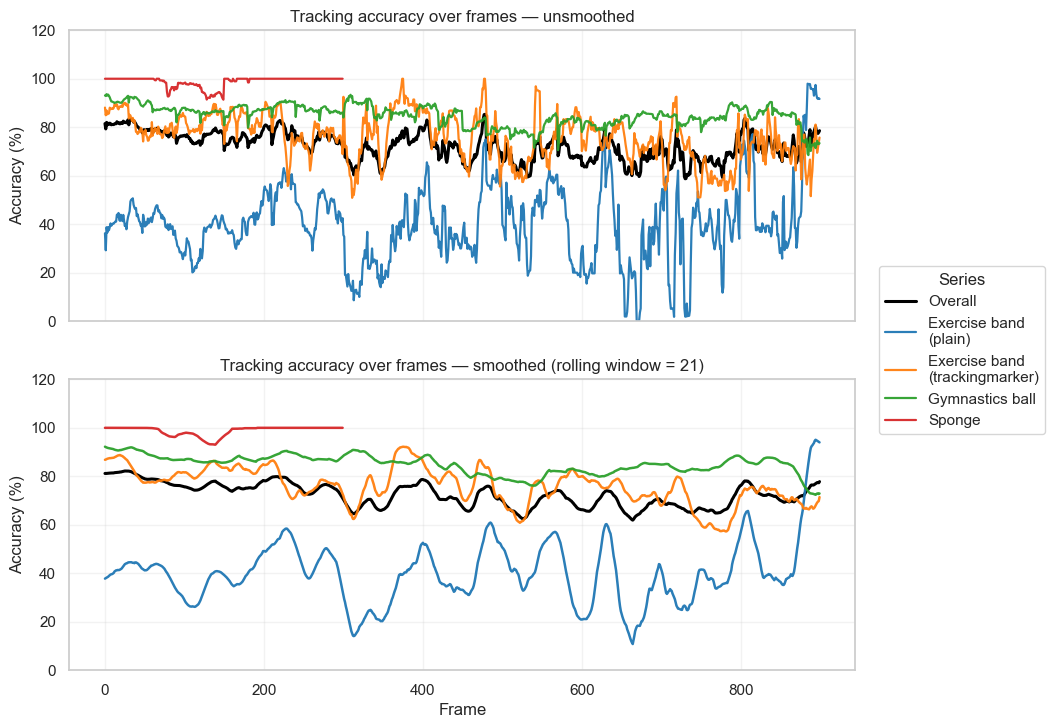

In [51]:
required_cols = {"frame", "accuracy_percent"}
rows = []
Y_LIMIT = (0, 120)

if "results" not in globals():
    raise NameError("Variable 'results' not found. Provide it as a list of dicts containing at least 'csv_path' and 'equipment_type'.")

for entry in results:
    csv_path = entry.get("csv_path")
    eq = entry.get("equipment_type")
    analysis_dir = entry.get("analysis_dir", "")

    # derive a run_id from the parent folder of 'analysis'
    # .../<eval_target>/analysis  -> run_id = <eval_target>
    run_id = os.path.basename(os.path.dirname(analysis_dir)) or os.path.basename(analysis_dir)

    if not csv_path or not os.path.isfile(csv_path):
        print(f"[skip] CSV not found: {csv_path}")
        continue

    try:
        tmp = pd.read_csv(
            csv_path,
            usecols=["frame", "accuracy_percent"]  # we only need these two for this plot
        )
    except Exception as e:
        print(f"[skip] Failed reading {csv_path}: {e}")
        continue

    if not required_cols.issubset(tmp.columns):
        print(f"[skip] Missing required cols in {csv_path}: {required_cols - set(tmp.columns)}")
        continue

    tmp = tmp.copy()
    tmp["frame"] = tmp["frame"].astype(int)
    tmp["accuracy_percent"] = tmp["accuracy_percent"].astype(float)
    tmp["equipment_type"] = eq
    tmp["run_id"] = run_id
    rows.append(tmp)

if not rows:
    raise RuntimeError("No CSV data collected. Check 'results' and file paths.")

df_frames = pd.concat(rows, ignore_index=True)
# apply human-readable equipment labels
df_frames["equipment_type"] = df_frames["equipment_type"].map(lambda v: LABEL_MAP.get(v, v))

# --- Aggregate over available runs per absolute frame index ---
# (Different run lengths are naturally handled; higher frames average over fewer runs.)
overall = (
    df_frames
    .groupby("frame")["accuracy_percent"]
    .mean()
    .reset_index()
    .sort_values("frame")
)

by_eq = (
    df_frames
    .groupby(["equipment_type", "frame"])["accuracy_percent"]
    .mean()
    .reset_index()
    .sort_values(["equipment_type", "frame"])
)

# --- Smoothed versions (rolling mean on the aggregated series) ---
def smooth(df, value_col="accuracy_percent", group_cols=None, window=SMOOTH_WINDOW_FRAMES):
    if group_cols is None:
        # single series
        d = df.sort_values("frame").copy()
        d["smoothed"] = d[value_col].rolling(window=window, center=True, min_periods=max(1, window // 3)).mean()
        return d
    else:
        # grouped series (per equipment)
        def _apply(g):
            g = g.sort_values("frame").copy()
            g["smoothed"] = g[value_col].rolling(window=window, center=True, min_periods=max(1, window // 3)).mean()
            return g
        return df.groupby(group_cols, group_keys=False).apply(_apply)

overall_s = smooth(overall, value_col="accuracy_percent", group_cols=None)
by_eq_s   = smooth(by_eq, value_col="accuracy_percent", group_cols=["equipment_type"])

# --- Plot: unsmoothed (top) and smoothed (bottom) ---
eq_list = sorted(df_frames["equipment_type"].unique())
palette = {}
colors = sns.color_palette("tab10", n_colors=max(10, len(eq_list)))
for i, eq in enumerate(eq_list):
    palette[eq] = colors[i % len(colors)]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# --- Top: UnsMoothed ---
ax1.plot(overall["frame"], overall["accuracy_percent"], color="black", lw=2.2, label="Overall")
for eq in eq_list:
    g = by_eq[by_eq["equipment_type"] == eq]
    ax1.plot(g["frame"], g["accuracy_percent"], lw=1.6, color=palette[eq], alpha=0.95, label=eq)

ax1.set_ylim(*Y_LIMIT)
ax1.set_ylabel("Accuracy (%)")
ax1.set_title("Tracking accuracy over frames — unsmoothed")
ax1.grid(True, axis="both", alpha=0.25)

# # place legend outside the top axis
# handles, labels = ax1.get_legend_handles_labels()
# ax1.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 1.02), ncol=3, frameon=True)

# --- Bottom: Smoothed ---
ax2.plot(overall_s["frame"], overall_s["smoothed"], color="black", lw=2.2, label="Overall (smoothed)")
for eq in eq_list:
    g = by_eq_s[by_eq_s["equipment_type"] == eq]
    ax2.plot(g["frame"], g["smoothed"], lw=1.8, color=palette[eq], alpha=0.95, label=f"{eq}")

ax2.set_ylim(*Y_LIMIT)
ax2.set_xlabel("Frame")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title(f"Tracking accuracy over frames — smoothed (rolling window = {SMOOTH_WINDOW_FRAMES})")
ax2.grid(True, axis="both", alpha=0.25)

# --- Single legend to the RIGHT for both subplots ---
# collect handles/labels from the top axis (avoid duplicates)
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # deduplicate while preserving last

# leave room on the right for the legend panel
fig.subplots_adjust(right=0.78, top=0.90, bottom=0.10)

fig.legend(
    list(by_label.values()),
    list(by_label.keys()),
    loc="center left",
    bbox_to_anchor=(0.80, 0.5),  # just outside the plotting area
    frameon=True,
    title="Series",
    borderaxespad=0.0,
)

plt.show()